In [1]:
#@title LICENSE
# Licensed under the Apache License, Version 2.0

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google-research/jaxpruner/blob/main/colabs/mnist_pruning.ipynb)

## Imports / Helpers

In [2]:
from absl import logging
import flax
import jax.numpy as jnp
from matplotlib import pyplot as plt
import numpy as np
import tensorflow_datasets as tfds
from flax import linen as nn
from flax.metrics import tensorboard
from flax.training import train_state
import jax
import optax
import tensorflow as tf
# Hide any GPUs form TensorFlow. Otherwise TF might reserve memory and make
# it unavailable to JAX.
tf.config.experimental.set_visible_devices([], "GPU")


logging.set_verbosity(logging.INFO)

In [3]:
!pip3 install git+https://github.com/google-research/jaxpruner
import jaxpruner
import ml_collections

  Cloning https://github.com/google-research/jaxpruner to /tmp/pip-req-build-l4sdp7ut
  Running command git clone --filter=blob:none --quiet https://github.com/google-research/jaxpruner /tmp/pip-req-build-l4sdp7ut
  Resolved https://github.com/google-research/jaxpruner to commit e7af4e4e4748782d6bc433249e359f74ffb845ba
  Preparing metadata (setup.py) ... done
  DEPRECATION: Building 'jaxpruner' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'jaxpruner'. Discussion can be found at https://github.com/pypa/pip/issues/6334
  Created wheel for jaxpruner: filename=jaxpruner-0.1-py3-none-any.whl size=48950 sha256=f37da610bead04878146834ad9f73b459934a2c3ebaf44341124ca5baa40616c
  Stored in directory:

## Dataset

In [4]:
def get_datasets():
  """Load MNIST train and test datasets into memory."""
  ds_builder = tfds.builder('mnist')
  ds_builder.download_and_prepare()
  train_ds = tfds.as_numpy(ds_builder.as_dataset(split='train', batch_size=-1))
  test_ds = tfds.as_numpy(ds_builder.as_dataset(split='test', batch_size=-1))
  train_ds['image'] = jnp.float32(train_ds['image']) / 255.
  test_ds['image'] = jnp.float32(test_ds['image']) / 255.
  return train_ds, test_ds

# Helper functions for images.

def show_img(img, ax=None, title=None):
  """Shows a single image."""
  if ax is None:
    ax = plt.gca()
  ax.imshow(img[..., 0], cmap='gray')
  ax.set_xticks([])
  ax.set_yticks([])
  if title:
    ax.set_title(title)

def show_img_grid(imgs, titles):
  """Shows a grid of images."""
  n = int(np.ceil(len(imgs)**.5))
  _, axs = plt.subplots(n, n, figsize=(3 * n, 3 * n))
  for i, (img, title) in enumerate(zip(imgs, titles)):
    show_img(img, axs[i // n][i % n], title)

In [5]:
# Get datasets as dict of JAX arrays.
train_ds, test_ds = get_datasets()

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


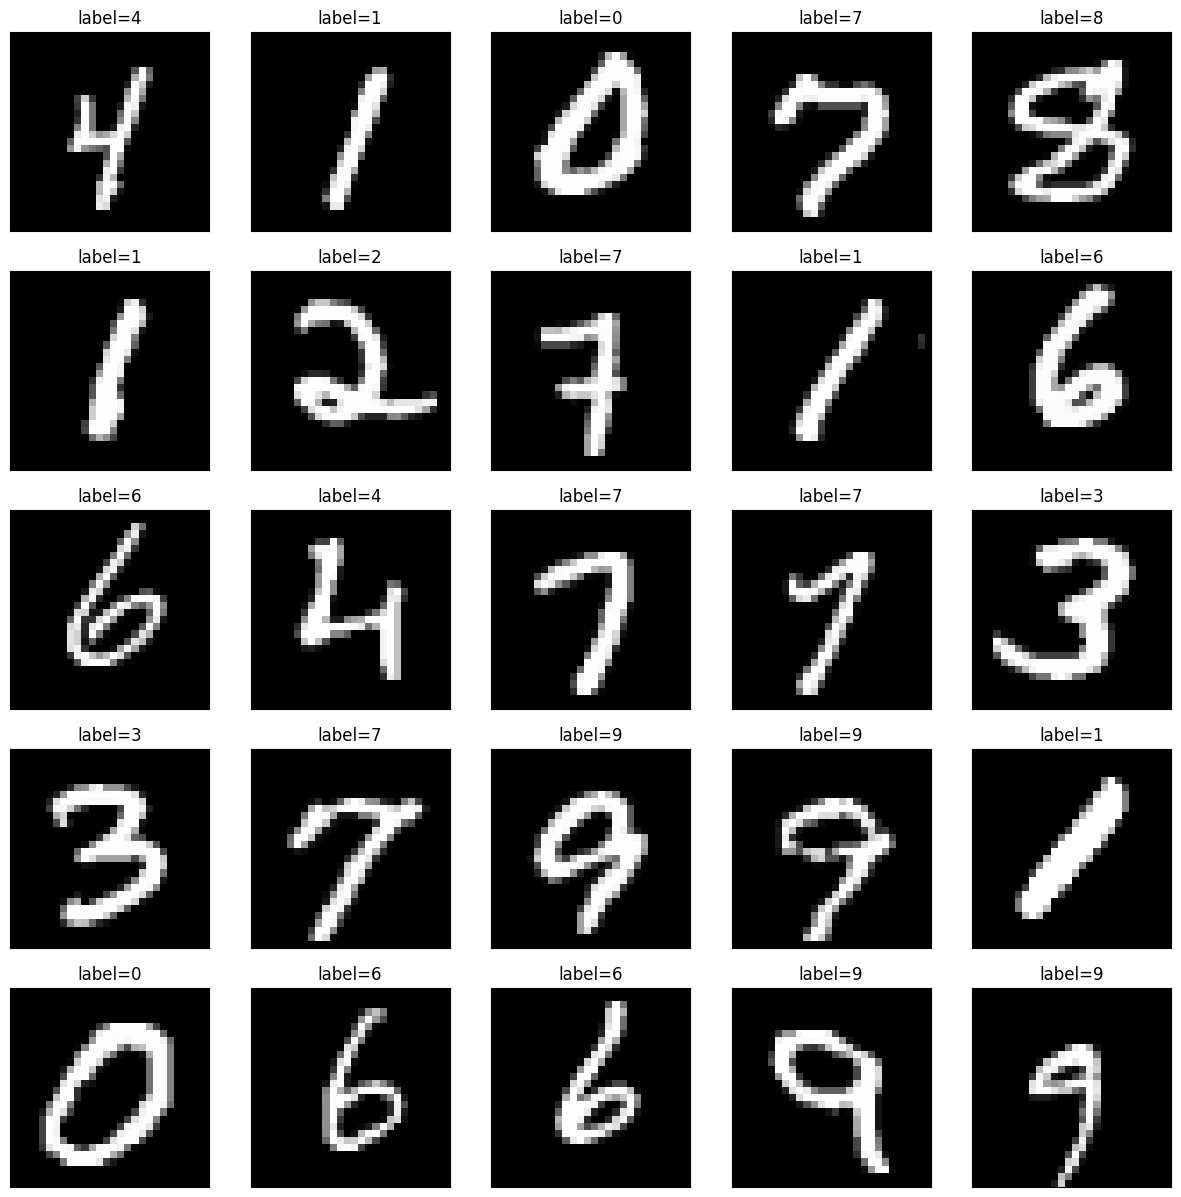

In [6]:
show_img_grid(
    [train_ds['image'][idx] for idx in range(25)],
    [f'label={train_ds["label"][idx]}' for idx in range(25)],
)

## Training

In [7]:
import ml_collections

class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x


@jax.jit
def apply_model(state, images, labels):
  """Computes gradients, loss and accuracy for a single batch."""
  def loss_fn(params):
    logits = state.apply_fn({'params': params}, images)
    one_hot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, loss, accuracy


@jax.jit
def update_model(state, grads):
  updates, new_opt_state = state.tx.update(
      grads, state.opt_state, state.params)
  new_params = optax.apply_updates(state.params, updates)
  return state.replace(
      step=state.step + 1,
      params=new_params,
      opt_state=new_opt_state)


def train_epoch(state, train_ds, batch_size, rng, sparsity_updater):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['image'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, len(train_ds['image']))
  perms = perms[:steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []
  epoch_accuracy = []
  is_ste = isinstance(sparsity_updater, (jaxpruner.SteMagnitudePruning,
                                         jaxpruner.SteRandomPruning))
  pre_op = jax.jit(sparsity_updater.pre_forward_update)
  post_op = jax.jit(sparsity_updater.post_gradient_update)
  for i, perm in enumerate(perms):
    batch_images = train_ds['image'][perm, ...]
    batch_labels = train_ds['label'][perm, ...]
    # Following is only needed for STE.
    new_params = pre_op(state.params, state.opt_state)
    forward_state = state.replace(params=new_params)

    grads, loss, accuracy = apply_model(forward_state, batch_images,
                                        batch_labels)
    state = update_model(state, grads)
    post_params = post_op(state.params, state.opt_state)
    state = state.replace(params=post_params)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
    if i % 100 == 0:
      if is_ste:
        print(jaxpruner.summarize_sparsity(
            new_params, only_total_sparsity=True))
      else:
        print(jaxpruner.summarize_sparsity(
            state.params, only_total_sparsity=True))
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy


def create_train_state(rng, config):
  """Creates initial `TrainState`."""
  cnn = CNN()
  params = cnn.init(rng, jnp.ones([1, 28, 28, 1]))['params']
  sparsity_updater = jaxpruner.create_updater_from_config(config.sparsity_config)
  tx = optax.sgd(config.learning_rate, config.momentum)
  tx = sparsity_updater.wrap_optax(tx)

  return train_state.TrainState.create(
      apply_fn=cnn.apply, params=params, tx=tx), sparsity_updater


import time

def train_and_evaluate(config: ml_collections.ConfigDict
                       ) -> train_state.TrainState:
  """Execute model training and evaluation loop.

  Args:
    config: Hyperparameter configuration for training and evaluation.
    workdir: Directory where the tensorboard summaries are written to.

  Returns:
    The train state (which includes the `.params`).
  """
  train_ds, test_ds = get_datasets()
  rng = jax.random.PRNGKey(0)

  rng, init_rng = jax.random.split(rng)

  state, sparsity_updater = create_train_state(init_rng, config)

  for epoch in range(1, config.num_epochs + 1):
    s_time = time.time()
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_accuracy = train_epoch(state, train_ds,
                                                    config.batch_size,
                                                    input_rng,
                                                    sparsity_updater)
    # Following is only needed for STE.
    new_params = sparsity_updater.pre_forward_update(
        state.params, state.opt_state)
    forward_state = state.replace(params=new_params)

    _, test_loss, test_accuracy = apply_model(forward_state, test_ds['image'],
                                              test_ds['label'])

    print(
        'epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f, test_accuracy: %.2f, time: %.2f'
        % (epoch, train_loss, train_accuracy * 100, test_loss,
           test_accuracy * 100, time.time() - s_time))

  return forward_state

# Jaxpruner API

In [8]:
jaxpruner.all_algorithm_names()

('no_prune',
 'magnitude',
 'random',
 'saliency',
 'magnitude_ste',
 'random_ste',
 'global_magnitude',
 'global_saliency',
 'static_sparse',
 'rigl',
 'set')

In [9]:
config = ml_collections.ConfigDict()

config.learning_rate = 0.1
config.momentum = 0.9
config.batch_size = 128
config.num_epochs = 3 # 1 epoch is 468 steps for bs=128

config.sparsity_config = ml_collections.ConfigDict()
config.sparsity_config.algorithm = 'magnitude'
config.sparsity_config.update_freq = 10
config.sparsity_config.update_end_step = 1000
config.sparsity_config.update_start_step = 200
config.sparsity_config.sparsity = 0.95
config.sparsity_config.dist_type = 'erk'

In [10]:
jaxpruner.create_updater_from_config(config.sparsity_config)

MagnitudePruning(scheduler=PolynomialSchedule(update_freq=10, update_start_step=200, update_end_step=1000, power=3), skip_gradients=False, is_sparse_gradients=False, sparsity_type=Unstructured(), sparsity_distribution_fn=functools.partial(<function erk at 0x7f010a362fc0>, sparsity=0.95), rng_seed=Array([0, 8], dtype=uint32), use_packed_masks=False, topk_fn=<function topk_mask_calculator at 0x7f010a362c00>)

In [11]:
# 3 epochs trains in 10 seconds in the GPU Colab...

state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(2.0623207e-05, dtype=float32), '_nparams_nnz': Array(824441., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0., dtype=float32), '_nparams_nnz': Array(824458., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.00355631, dtype=float32), '_nparams_nnz': Array(821526., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.316158, dtype=float32), '_nparams_nnz': Array(563799., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.5509765, dtype=float32), '_nparams_nnz': Array(370201., dtype=float32), '_nparams': Array(824458., dtype=float32)}


2025-07-21 22:44:41.058036: E external/xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng57{k2=0,k13=2,k14=2,k18=1,k23=0} for conv %cudnn-conv-bw-filter.2 = (f32[32,1,3,3]{3,2,1,0}, u8[0]{0}) custom-call(%bitcast.99, %select.3), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", metadata={op_name="jit(apply_model)/jit(main)/transpose(jvp(CNN))/Conv_0/conv_general_dilated" source_file="/tmp/ipykernel_310629/3953316287.py" source_line=8}, backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]} is taking a while...
2025-07-21 22:44:41.149177: E external/xla/xla/service/slow_operation_alarm.cc:140] The operation took 1.09122487s
Trying algorithm eng57{k2=0,k13=2,k14=2,k18=1,k23=0} for conv %cudnn-conv-bw-filter.2 = (f32[32,1,3,3]{3,2,

epoch:  1, train_loss: 0.2275, train_accuracy: 93.40, test_loss: 0.0475, test_accuracy: 98.35, time: 16.21
{'_total_sparsity': Array(0.6591591, dtype=float32), '_nparams_nnz': Array(281009., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.79266864, dtype=float32), '_nparams_nnz': Array(170936., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.8773279, dtype=float32), '_nparams_nnz': Array(101138., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.92426175, dtype=float32), '_nparams_nnz': Array(62443., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.9446, dtype=float32), '_nparams_nnz': Array(45675., dtype=float32), '_nparams': Array(824458., dtype=float32)}
epoch:  2, train_loss: 0.0540, train_accuracy: 98.37, test_loss: 0.0385, test_accuracy: 98.71, time: 1.16
{'_total_sparsity': Array(0.9489725, dtype=float32), '_nparams_nnz': Array(

# One Shot pruning

In [12]:
config.sparsity_config.update_start_step = 0
config.sparsity_config.update_end_step = 0
config.sparsity_config.skip_gradients=True
state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(0.9500205, dtype=float32), '_nparams_nnz': Array(41206., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958264, dtype=float32), '_nparams_nnz': Array(41567., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958264, dtype=float32), '_nparams_nnz': Array(41567., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958264, dtype=float32), '_nparams_nnz': Array(41567., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958264, dtype=float32), '_nparams_nnz': Array(41567., dtype=float32), '_nparams': Array(824458., dtype=float32)}
epoch:  1, train_loss: 0.3879, train_accuracy: 88.22, test_loss: 0.1368, test_accuracy: 95.81, time: 5.01
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144,

# STE

In [13]:
# STE also supports gradual pruning schedules.
# Here we train weights with sparse forward pass from the start.
config.sparsity_config.algorithm = 'magnitude_ste'
config.sparsity_config.sparsity = 0.95
config.sparsity_config.update_end_step = 0
config.sparsity_config.update_start_step = 0
config.sparsity_config.dist_type = 'erk'
state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(0.9500205, dtype=float32), '_nparams_nnz': Array(41206., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
epoch:  1, train_loss: 0.3378, train_accuracy: 89.77, test_loss: 0.0959, test_accuracy: 96.70, time: 7.76
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144,

# Global Pruning

In [14]:
config.sparsity_config.algorithm = 'global_magnitude'
config.sparsity_config.update_freq = 10
config.sparsity_config.update_end_step = 1000
config.sparsity_config.update_start_step = 200
config.sparsity_config.sparsity = 0.95
config.sparsity_config.dist_type = 'erk'

state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(2.0623207e-05, dtype=float32), '_nparams_nnz': Array(824441., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0., dtype=float32), '_nparams_nnz': Array(824458., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.00355631, dtype=float32), '_nparams_nnz': Array(821526., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.31615925, dtype=float32), '_nparams_nnz': Array(563798., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.5509777, dtype=float32), '_nparams_nnz': Array(370200., dtype=float32), '_nparams': Array(824458., dtype=float32)}
epoch:  1, train_loss: 0.2300, train_accuracy: 93.30, test_loss: 0.0487, test_accuracy: 98.40, time: 4.89
{'_total_sparsity': Array(0.65916157, dtype=float32), '_nparams_nnz': Array(281007., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.7926711,

In [15]:
jaxpruner.summarize_sparsity(state.opt_state.masks)

{'Conv_0/bias': None,
 'Conv_0/kernel': Array(0.05902779, dtype=float32),
 'Conv_1/bias': None,
 'Conv_1/kernel': Array(0.3928494, dtype=float32),
 'Dense_0/bias': None,
 'Dense_0/kernel': Array(0.96527475, dtype=float32),
 'Dense_1/bias': None,
 'Dense_1/kernel': Array(0.27148438, dtype=float32),
 '_total_sparsity': Array(0.94999975, dtype=float32),
 '_nparams_nnz': Array(41205., dtype=float32),
 '_nparams': Array(824096., dtype=float32)}

# Dynamic Sparse Training

In [16]:
config.sparsity_config.algorithm = 'rigl'

config.sparsity_config.update_freq = 10
config.sparsity_config.update_end_step = 1000
config.sparsity_config.update_start_step = 1
config.sparsity_config.sparsity = 0.95
config.sparsity_config.dist_type = 'erk'

state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(0.94960207, dtype=float32), '_nparams_nnz': Array(41551., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.95216006, dtype=float32), '_nparams_nnz': Array(39442., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.9525822, dtype=float32), '_nparams_nnz': Array(39094., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.95235294, dtype=float32), '_nparams_nnz': Array(39283., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.9519308, dtype=float32), '_nparams_nnz': Array(39631., dtype=float32), '_nparams': Array(824458., dtype=float32)}
epoch:  1, train_loss: 0.4458, train_accuracy: 85.65, test_loss: 0.1272, test_accuracy: 96.03, time: 7.30
{'_total_sparsity': Array(0.9495851, dtype=float32), '_nparams_nnz': Array(41565., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144, d

In [17]:
config.sparsity_config.algorithm = 'set'
state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(0.94960207, dtype=float32), '_nparams_nnz': Array(41551., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.95409954, dtype=float32), '_nparams_nnz': Array(37843., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.9537854, dtype=float32), '_nparams_nnz': Array(38102., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.9532699, dtype=float32), '_nparams_nnz': Array(38527., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.9526186, dtype=float32), '_nparams_nnz': Array(39064., dtype=float32), '_nparams': Array(824458., dtype=float32)}
epoch:  1, train_loss: 0.4882, train_accuracy: 84.93, test_loss: 0.1544, test_accuracy: 95.17, time: 8.21
{'_total_sparsity': Array(0.95026916, dtype=float32), '_nparams_nnz': Array(41001., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.9501333, dt

In [18]:
config.sparsity_config.algorithm = 'static_sparse'

state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(0.94960207, dtype=float32), '_nparams_nnz': Array(41551., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
epoch:  1, train_loss: 0.4862, train_accuracy: 84.91, test_loss: 0.1684, test_accuracy: 94.84, time: 3.43
{'_total_sparsity': Array(0.94958144, dtype=float32), '_nparams_nnz': Array(41568., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0.94958144

# Pruning After Training

In [19]:
config.sparsity_config.algorithm = 'no_prune'
state = train_and_evaluate(config)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


{'_total_sparsity': Array(2.0623207e-05, dtype=float32), '_nparams_nnz': Array(824441., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0., dtype=float32), '_nparams_nnz': Array(824458., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0., dtype=float32), '_nparams_nnz': Array(824458., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0., dtype=float32), '_nparams_nnz': Array(824458., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0., dtype=float32), '_nparams_nnz': Array(824458., dtype=float32), '_nparams': Array(824458., dtype=float32)}
epoch:  1, train_loss: 0.2289, train_accuracy: 93.35, test_loss: 0.0520, test_accuracy: 98.17, time: 3.02
{'_total_sparsity': Array(0., dtype=float32), '_nparams_nnz': Array(824458., dtype=float32), '_nparams': Array(824458., dtype=float32)}
{'_total_sparsity': Array(0., dtype=float32), '_nparams_nnz': Array

In [20]:
config.sparsity_config.algorithm = 'magnitude'
config.sparsity_config.sparsity = 0.9
sparsity_updater = jaxpruner.create_updater_from_config(config.sparsity_config)
pruned_params, _ = sparsity_updater.instant_sparsify(state.params)
print(jaxpruner.summarize_sparsity(pruned_params, only_total_sparsity=True))

{'_total_sparsity': Array(0.8996031, dtype=float32), '_nparams_nnz': Array(82773., dtype=float32), '_nparams': Array(824458., dtype=float32)}


In [21]:
_, test_ds = get_datasets()
pruned_state = state.replace(params=pruned_params)
_, _, test_accuracy  = apply_model(pruned_state, test_ds['image'], test_ds['label'])
print(test_accuracy*100)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


98.759995


# N:M sparsity

In [27]:
for ln in state.params:
    for wn in state.params[ln]:
        print(ln + wn, state.params[ln][wn].shape)

Conv_0bias (32,)
Conv_0kernel (3, 3, 1, 32)
Conv_1bias (64,)
Conv_1kernel (3, 3, 32, 64)
Dense_0bias (256,)
Dense_0kernel (3136, 256)
Dense_1bias (10,)
Dense_1kernel (256, 10)


In [28]:
config.sparsity_config.algorithm = 'magnitude'
config.sparsity_config.sparsity_type = 'nm_1,2'
sparsity_updater = jaxpruner.create_updater_from_config(config.sparsity_config)
pruned_params, masks = sparsity_updater.instant_sparsify(state.params)
print(jaxpruner.summarize_sparsity(pruned_params, only_total_sparsity=True))

{'_total_sparsity': Array(0.49805325, dtype=float32), '_nparams_nnz': Array(413834., dtype=float32), '_nparams': Array(824458., dtype=float32)}


In [29]:
masks['Dense_0']['kernel'][0][:16]

Array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1], dtype=uint8)

In [30]:
_, test_ds = get_datasets()
pruned_state = state.replace(params=pruned_params)
_, _, test_accuracy  = apply_model(pruned_state, test_ds['image'], test_ds['label'])
print(test_accuracy*100)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


98.799995


# Block Sparsity

In [31]:
config.sparsity_config.algorithm = 'magnitude'
config.sparsity_config.sparsity = 0.7
config.sparsity_config.sparsity_type = 'block_2,2'
sparsity_updater = jaxpruner.create_updater_from_config(config.sparsity_config)
pruned_params, masks = sparsity_updater.instant_sparsify(state.params)
print(jaxpruner.summarize_sparsity(pruned_params, only_total_sparsity=True))

{'_total_sparsity': Array(0.700892, dtype=float32), '_nparams_nnz': Array(246602., dtype=float32), '_nparams': Array(824458., dtype=float32)}


In [32]:
masks['Dense_0']['kernel'][:4, :16]

Array([[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=uint8)

In [33]:
_, test_ds = get_datasets()
pruned_state = state.replace(params=pruned_params)
_, _, test_accuracy  = apply_model(pruned_state, test_ds['image'], test_ds['label'])
print(test_accuracy*100)

INFO:absl:Load dataset info from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Reusing dataset mnist (/home/dima/tensorflow_datasets/mnist/3.0.1)
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split train, from /home/dima/tensorflow_datasets/mnist/3.0.1
INFO:absl:Creating a tf.data.Dataset reading 1 files located in folders: /home/dima/tensorflow_datasets/mnist/3.0.1.
INFO:absl:Constructing tf.data.Dataset mnist for split test, from /home/dima/tensorflow_datasets/mnist/3.0.1


60.52
